# About 

    This notebook involves further feature engineering on the Indian Metropolitian Cities housing price dataset. The features added here will be build from the 2011 census dataset, and then doing a spatial join with the dataset from part 1 notebook.
    
**Part 1 feature processing notebook**: https://www.kaggle.com/code/virajkadam/geocoding-and-feature-eng-housing-price-dataset

# Imports

In [1]:
file_download_link = 'https://drive.google.com/uc?id=194zmr7i-ff0XQi1p2z422zw1gKcUhXPH'

In [2]:
#downloading census dataset
!wget $file_download_link -O cities_census11.csv -q

In [3]:
import pandas as pd 
import numpy as np 
import gc
import geopandas as gpd
import matplotlib.pyplot as plt

import folium
from folium.plugins import HeatMap
import geopy as gp
import ee
import ast

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


pd.set_option('display.max_rows',None)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


**Loading files**

In [4]:
#census data 
census_ds = pd.read_csv('./cities_census11.csv',
                        header=None,
                        index_col=0,skiprows=1)
#col names
col_names = pd.read_csv('../input/geocoding-census-housing-dataset/hlpca-colnames.csv',header=None)
census_ds.columns  = col_names.values.ravel().tolist()
census_ds.head()

,State Code,State Name,District Code,District Name,Tehsil Code,Tehsil Name,Town Code/Village code,Ward No,Area Name,Rural/Urban,...,Availability of assets: Scooter/Motorcycle/Moped,Availability of assets: Car/Jeep/Van,Availability of assets: Households with TV,Availability of assets: None of the assets specified in col. 10 to 19,Households by Type of Structure of Census Houses: Permanent,Households by Type of Structure of Census Houses: Semi-Permanent,Households by Type of Structure of Census Houses: Total Temporary,Households by Type of Structure of Census Houses: Serviceable,Households by Type of Structure of Census Houses: Non-Serviceable,Households by Type of Structure of Census Houses: Unclassifiable
0,,,,,,,,,,,,,,,,,,,,,
0,28,ANDHRA PRADESH,536,Hyderabad,0,Hyderabad,0,0,District - Hyderabad,Total,...,49.9,14.1,22.7,3.1,91.4,6.8,1.1,0.5,0.6,0.6
1,28,ANDHRA PRADESH,536,Hyderabad,0,Hyderabad,0,0,District - Hyderabad,Urban,...,49.9,14.1,22.7,3.1,91.4,6.8,1.1,0.5,0.6,0.6
2,28,ANDHRA PRADESH,536,Hyderabad,4496,Shaikpet,0,0,Sub-Dist - Shaikpet,Total,...,38.9,21.2,25.7,3.7,91.5,5.0,2.9,0.6,2.4,0.5
3,28,ANDHRA PRADESH,536,Hyderabad,4496,Shaikpet,0,0,Sub-Dist - Shaikpet,Urban,...,38.9,21.2,25.7,3.7,91.5,5.0,2.9,0.6,2.4,0.5
4,28,ANDHRA PRADESH,536,Hyderabad,4496,Shaikpet,802918,0,GHMC (M Corp.) (Part),Urban,...,38.9,21.2,25.7,3.7,91.5,5.0,2.9,0.6,2.4,0.5


In [5]:
census_ds['address'] = census_ds['Area Name']+' '+census_ds['District Name']+ ' '+ census_ds['State Name']

census_ds['address']  = census_ds['address'].str.lower()

census_ds['address'].nunique()

1905

In [6]:
census_ds['State Name'].unique()

array(['ANDHRA PRADESH', 'KARNATAKA', 'TAMIL NADU', 'MAHARASHTRA',
       'NCT OF DELHI', 'WEST BENGAL'], dtype=object)

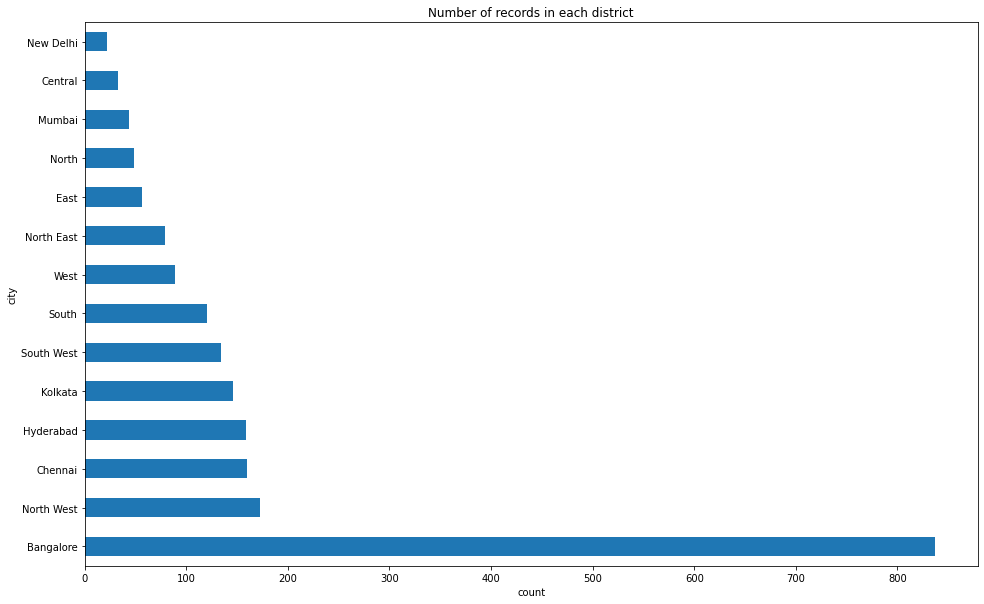

In [7]:
ax = census_ds['District Name'].value_counts().plot.barh(figsize=(16,10))
ax.set(**{'title':'Number of records in each district',
          'xlabel' : 'count',
          'ylabel':'city'})

plt.show()

# Calculating indices

In [8]:
bai_cols=[81,84,90,102,105,119,113,126]# Indices of basic amenities columns
ai_cols=list(range(127,137))  # Indices of assets columns
qhi_cols=[15,62,50,51,52,53,54,139]  # Indices of quality of housing index columns
hqli_cols=bai_cols+ai_cols+qhi_cols # Combine all three categories of 

In [9]:
#df to store calculated indices
indices_df = census_ds[['address']].copy(deep=True)

In [11]:
pca_pipeline = Pipeline(steps = [('standard_scaler',StandardScaler()),
                                 ('pca',PCA(n_components=5))
                                 ]
                       )


    

In [ ]:

# df_qhli=census_ds.iloc[:,hqli_cols]  # Create a dataframe using hqli_cols

# pc_df= pd.DataFrame(pca_pipeline.fit_transform(df_qhli),
#                       columns=[f'pc{i}' for i in range(1,6)])


#store the PCA components obtained in a dataframe
# pca_comp_cities_df = pd.DataFrame(pca_pipeline['pca'].components_,
#                                   columns=hqli_cols,
#                                   index=pc_df.columns)

# pc1_comp = pc_df.iloc[0,:].values #components of first PC

# pca_comp_cities_df.head()    

In [12]:
def calculate_index(
               columns_index,
               df = census_ds):
    '''calculate indexes, by sum after multiplying the pc1 with features in that index. '''
    
    col_df = df.iloc[:,columns_index]
#     col_df_std = StandardScaler().fit_transform(col_df)
    
    pca = pca_pipeline.fit_transform(col_df)

    index_value = pca[:,0]
    assert len(index_value) == len(col_df), 'Why do you make life hard for everyone'
    
    
    return index_value
    
    

**Basic Aminities index**

In [48]:
#BAI
census_ds.iloc[:,bai_cols].columns.tolist()

['Location of drinking water source: Within premises',
 'Main Source of lighting: Electricity',
 'Number of households having latrine facility within the premises',
 'Number of households having bathing facility within the premises: Yes (Bathroom)',
 'Waste water outlet connected to: Closed drainage',
 'Kitchen facility: Cooking inside house:',
 'Type of Fuel used for Cooking: LPG/PNG',
 'Total number of households availing banking services']

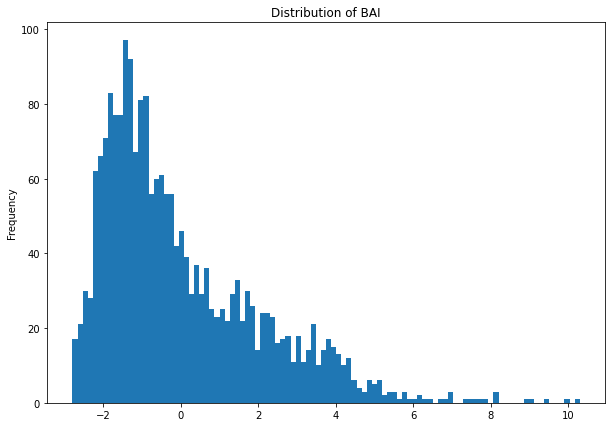

In [49]:
bai = calculate_index(columns_index=bai_cols)

#store bai 
indices_df['rel_bai'] = bai

indices_df['rel_bai'].plot.hist(title='Distribution of BAI',figsize=(10,7),bins=100)
plt.show()


**Assets index**

In [47]:
#AI
census_ds.iloc[:,ai_cols].columns.tolist()

['Availability of assets: Radio/Transistor',
 'Availability of assets: Television',
 'Availability of assets: Computer/Laptop (With Internet)',
 'Availability of assets: Computer/Laptop (Without Internet)',
 'Availability of assets: Telephone/Mobile Phone (Landline only)',
 'Availability of assets: Telephone/Mobile Phone (Mobile only)',
 'Availability of assets: Telephone/Mobile Phone (Both)',
 'Availability of assets: Bicycle',
 'Availability of assets: Scooter/Motorcycle/Moped',
 'Availability of assets: Car/Jeep/Van']

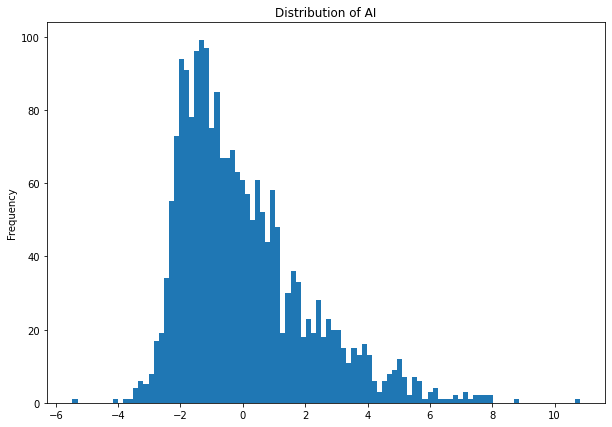

In [14]:
ai = calculate_index(columns_index=ai_cols)

#store bai 
indices_df['rel_ai'] = ai

indices_df['rel_ai'].plot.hist(title='Distribution of AI',figsize=(10,7),bins=100)
plt.show()


**Quality of housing index**

In [46]:
#QHI
census_ds.iloc[:,qhi_cols].columns.tolist()

['Number of households with condition of Census House as: Residence (Good)',
 'Ownership status: Owned',
 'Number of Dwelling Rooms: Two rooms',
 'Number of Dwelling Rooms: Three rooms',
 'Number of Dwelling Rooms: Four rooms',
 'Number of Dwelling Rooms: Five rooms',
 'Number of Dwelling Rooms: Six rooms and above',
 'Households by Type of Structure of Census Houses: Permanent']

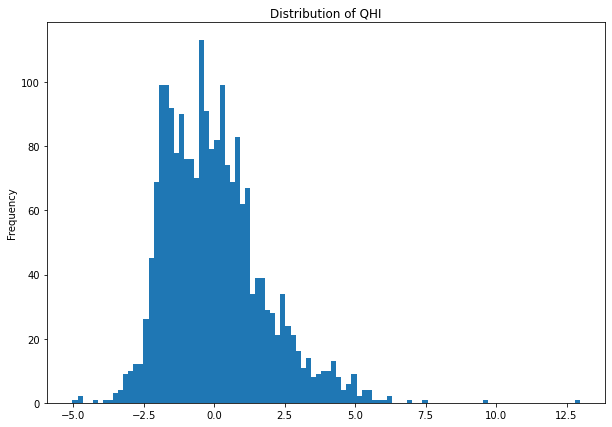

In [15]:
qhi = calculate_index(columns_index=qhi_cols)

#store bai 
indices_df['rel_qhi'] = qhi

indices_df['rel_qhi'].plot.hist(title='Distribution of QHI',figsize=(10,7),bins=100)
plt.show()


**HQLI**

In [45]:
#HQLI
census_ds.iloc[:,hqli_cols].columns.tolist()

['Location of drinking water source: Within premises',
 'Main Source of lighting: Electricity',
 'Number of households having latrine facility within the premises',
 'Number of households having bathing facility within the premises: Yes (Bathroom)',
 'Waste water outlet connected to: Closed drainage',
 'Kitchen facility: Cooking inside house:',
 'Type of Fuel used for Cooking: LPG/PNG',
 'Total number of households availing banking services',
 'Availability of assets: Radio/Transistor',
 'Availability of assets: Television',
 'Availability of assets: Computer/Laptop (With Internet)',
 'Availability of assets: Computer/Laptop (Without Internet)',
 'Availability of assets: Telephone/Mobile Phone (Landline only)',
 'Availability of assets: Telephone/Mobile Phone (Mobile only)',
 'Availability of assets: Telephone/Mobile Phone (Both)',
 'Availability of assets: Bicycle',
 'Availability of assets: Scooter/Motorcycle/Moped',
 'Availability of assets: Car/Jeep/Van',
 'Number of households wit

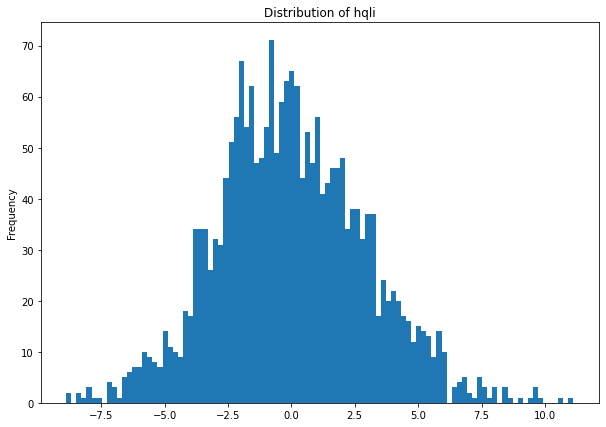

In [16]:
hqli = calculate_index(columns_index=hqli_cols)

#store bai 
indices_df['rel_hqli'] = hqli

indices_df['rel_hqli'].plot.hist(title='Distribution of hqli',figsize=(10,7),bins=100)
plt.show()

In [17]:
indices_df.head()

,address,rel_bai,rel_ai,rel_qhi,rel_hqli
0,,,,,
0,district - hyderabad hyderabad andhra pradesh,-1.228847,0.623101,0.634300,-1.544643
1,district - hyderabad hyderabad andhra pradesh,-1.228847,0.623101,0.634300,-1.544643
2,sub-dist - shaikpet hyderabad andhra pradesh,-1.071748,0.687670,0.887902,-1.469869
3,sub-dist - shaikpet hyderabad andhra pradesh,-1.071748,0.687670,0.887902,-1.469869
4,ghmc (m corp.) (part) hyderabad andhra pradesh,-1.071748,0.687670,0.887902,-1.469869


# Geocoding Address

In [22]:


arcgis_geocoder = gp.geocoders.ArcGIS()

def geocode(address:list,
            geocoder=arcgis_geocoder):
    
    '''geocode a list a addresses, returning the address and lat/long'''
    
    lat,lon = [],[]
    
    for add in address:
        
        try :
            coded = geocoder.geocode(add)
            
            lat.append(coded.latitude)
            lon.append(coded.longitude)
            
        except Exception as e:
            print(e)
            
            lat.append(np.nan)
            lon.append(np.nan)
            
            
    return pd.DataFrame({'Address':address,
                         'latitude':lat,
                         'longitude':lon})
            




In [25]:
# %%time
geocoded_census = geocode(address= census_ds.address.unique())
    
#save location info
geocoded_census.to_csv('census_housing_cities_geocoded.csv',
                       index=False)

geocoded_census.head()

,Address,latitude,longitude
0,district - hyderabad hyderabad andhra pradesh,17.25,78.5
1,sub-dist - shaikpet hyderabad andhra pradesh,17.25,78.5
2,ghmc (m corp.) (part) hyderabad andhra pradesh,17.25,78.5
3,ghmc (m corp.) (part) - ward no.104 hyderabad ...,17.25,78.5
4,ghmc (m corp.) (part) - ward no.105 hyderabad ...,17.25,78.5


In [26]:
geocoded_census=geocoded_census.merge(indices_df,left_on='Address',right_on='address',how='inner')
geocoded_census.shape

(2101, 8)

# HeatMap of geocoded locations just to be sure 

In [27]:
m1 = folium.Map(location = (geocoded_census['latitude'].mean(),geocoded_census['longitude'].mean()),zoom_start=7,min_zoom=5)

hm = HeatMap(data = geocoded_census[['latitude','longitude']],
             radius=10,
             blur=15,
             opacity=0.8)

hm.add_to(m1)

m1

**Converting crs for calculation of distance in meters**

In [28]:
geocoded_census_gdf = gpd.GeoDataFrame(geocoded_census,crs = 'EPSG:4326',
                        geometry = gpd.points_from_xy(geocoded_census['longitude'],
                                                      geocoded_census['latitude'])
                                      ) #cnv to geodf


geocoded_census_gdf=geocoded_census_gdf.to_crs(epsg = 24381)

geocoded_census_gdf.head()

,Address,latitude,longitude,address,rel_bai,rel_ai,rel_qhi,rel_hqli,geometry
0,district - hyderabad hyderabad andhra pradesh,17.25,78.5,district - hyderabad hyderabad andhra pradesh,-1.228847,0.623101,0.634300,-1.544643,POINT (2583964.479 721486.627)
1,district - hyderabad hyderabad andhra pradesh,17.25,78.5,district - hyderabad hyderabad andhra pradesh,-1.228847,0.623101,0.634300,-1.544643,POINT (2583964.479 721486.627)
2,sub-dist - shaikpet hyderabad andhra pradesh,17.25,78.5,sub-dist - shaikpet hyderabad andhra pradesh,-1.071748,0.687670,0.887902,-1.469869,POINT (2583964.479 721486.627)
3,sub-dist - shaikpet hyderabad andhra pradesh,17.25,78.5,sub-dist - shaikpet hyderabad andhra pradesh,-1.071748,0.687670,0.887902,-1.469869,POINT (2583964.479 721486.627)
4,ghmc (m corp.) (part) hyderabad andhra pradesh,17.25,78.5,ghmc (m corp.) (part) hyderabad andhra pradesh,-1.071748,0.687670,0.887902,-1.469869,POINT (2583964.479 721486.627)


# Loading geocoded housing dataset

In [29]:
housing_geocoded = pd.read_csv('../input/geocoding-and-feature-processing-housing-data/geocoded.csv')
housing_geocoded = gpd.GeoDataFrame(housing_geocoded,crs = 'EPSG:4326',
                                   geometry = gpd.points_from_xy(housing_geocoded['longitude'],
                                                                 housing_geocoded['latitude'])
                                   ) #cnv to geodf


housing_geocoded=housing_geocoded.to_crs(epsg = 24381)

housing_geocoded.head()

,Address,latitude,longitude,geometry
0,"jp nagar phase 1, bangalore, karnataka",12.909960,77.585660,POINT (2480213.366 241747.681)
1,"dasarahalli on tumkur road, bangalore, karnataka",13.058416,77.468358,POINT (2467666.390 258418.588)
2,"kannur on thanisandra main road, bangalore, ka...",13.097668,77.635770,POINT (2485954.731 262524.740)
3,"doddanekundi, bangalore, karnataka",12.978390,77.707320,POINT (2493571.687 249172.635)
4,"kengeri, bangalore, karnataka",12.908680,77.487180,POINT (2469478.439 241755.706)


In [30]:
housing_geocoded.crs

<Projected CRS: EPSG:24381>
Name: Kalianpur 1975 / India zone IIIa
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: India - onshore between 15°N and 21°N.
- bounds: (70.14, 15.0, 87.15, 21.01)
Coordinate Operation:
- name: India zone IIIa (1975 metres)
- method: Lambert Conic Conformal (1SP)
Datum: Kalianpur 1975
- Ellipsoid: Everest 1830 (1975 Definition)
- Prime Meridian: Greenwich

In [31]:
#measure distance between points
housing_geocoded.iloc[1000:1010].geometry.distance(housing_geocoded.geometry[1000])

1000         0.000000
1001     32385.020605
1002     31125.716743
1003      5032.878540
1004     11067.980887
1005     15241.096204
1006     18460.046620
1007     27685.374910
1008     31275.152049
1009    129169.650041
dtype: float64

# Spatial joining census data with housing data addresses

In [32]:
housing_geocoded.shape


(1789, 4)

In [33]:
housing_pls_census_data = housing_geocoded.sjoin_nearest(geocoded_census_gdf,
                                       how='inner',
                                       max_distance = 50000 #max distance in kms
                                                        ).groupby('Address_left').first().reset_index() 


**How many rows are not joined??**

In [34]:
housing_geocoded[~pd.Series(housing_geocoded.Address.unique()).isin(housing_pls_census_data.Address_left)].shape

(35, 4)

# Merging the data with housing data

In [36]:
hs_df = housing_pls_census_data[['Address_left','rel_bai','rel_ai','rel_qhi','rel_hqli']].rename(columns={'Address_left':'Address'})

hs_df.shape

(1754, 5)

In [37]:
final_df = pd.read_csv('../input/geocoding-and-feature-processing-housing-data/final_df.csv')
final_df.head()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,HDC_1990,Inhabited areas_1990,LDC_2000,HDC_2000,Inhabited areas_2000,RUR_2000,HDC_2014,RUR_2014,LDC_2014,Inhabited areas_2014
0,30000000,3340,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,...,20.901961,0.0,0.172549,27.815686,0.0,0.0,27.988235,0.0,0.0,0.0
1,30000000,3340,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,...,20.901961,0.0,0.172549,27.815686,0.0,0.0,27.988235,0.0,0.0,0.0
2,30000000,3340,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,...,20.901961,0.0,0.172549,27.815686,0.0,0.0,27.988235,0.0,0.0,0.0
3,29600000,3300,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,...,20.901961,0.0,0.172549,27.815686,0.0,0.0,27.988235,0.0,0.0,0.0
4,2899000,3145,JP Nagar Phase 1,4.0,1,NaN,NaN,NaN,NaN,NaN,...,20.901961,0.0,0.172549,27.815686,0.0,0.0,27.988235,0.0,0.0,0.0


In [39]:
final_df.isnull().sum()

Price                       0
Area                        0
Location                    0
No. of Bedrooms             1
Resale                      0
MaintenanceStaff        22870
Gymnasium               22870
SwimmingPool            22870
LandscapedGardens       22870
JoggingTrack            22870
RainWaterHarvesting     22870
IndoorGames             22870
ShoppingMall            22870
Intercom                22870
SportsFacility          22870
ATM                     22870
ClubHouse               22870
School                  22870
24X7Security            22870
PowerBackup             22870
CarParking              22870
StaffQuarter            22870
Cafeteria               22870
MultipurposeRoom        22870
Hospital                22870
WashingMachine          22870
Gasconnection           22870
AC                      22870
Wifi                    22870
Children'splayarea      22870
LiftAvailable           22870
BED                     22870
VaastuCompliant         22870
Microwave 

In [40]:
final_df2 = final_df.merge(hs_df,
                           on='Address',
                           how='left')

final_df2.shape

(32963, 74)

In [41]:
final_df2.head()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,Inhabited areas_2000,RUR_2000,HDC_2014,RUR_2014,LDC_2014,Inhabited areas_2014,rel_bai,rel_ai,rel_qhi,rel_hqli
0,30000000,3340,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,27.988235,0.0,0.0,0.0,2.194016,-1.176683,-1.625701,3.226242
1,30000000,3340,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,27.988235,0.0,0.0,0.0,2.194016,-1.176683,-1.625701,3.226242
2,30000000,3340,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,27.988235,0.0,0.0,0.0,2.194016,-1.176683,-1.625701,3.226242
3,29600000,3300,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,27.988235,0.0,0.0,0.0,2.194016,-1.176683,-1.625701,3.226242
4,2899000,3145,JP Nagar Phase 1,4.0,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,27.988235,0.0,0.0,0.0,2.194016,-1.176683,-1.625701,3.226242


In [42]:
final_df2.to_csv('final_df2.csv',index=False)

In [43]:
!ls -l

total 21688
---------- 1 root root      263 Apr 13 08:57 __notebook_source__.ipynb
-rw-r--r-- 1 root root   156177 Apr 13 09:05 census_housing_cities_geocoded.csv
-rw-r--r-- 1 root root  1431246 Apr 13 08:59 cities_census11.csv
-rw-r--r-- 1 root root 20610046 Apr 13 09:14 final_df2.csv
